# Performance testing analysis

- CPU: 2 x Intel(R) Xeon(R) CPU E5-2660 v2 @ 2.20GHz
- RAM: 4 x 32 Gb DDR3 @ 800MHz (1.2ns)
- SSD: 2Tb


### Create DataFrame

In [3]:
import json
from pathlib import Path

import numpy as np
import pandas as pd

RESULTS_DIR = Path(".")

def load_k6_summary(path: Path) -> dict:
    with path.open() as f:
        return json.load(f)


def infer_alg_from_filename(path: Path) -> str:
    """
    Examples:
      20251122T142037-hs256.json -> hs256
      hs256.json                 -> hs256
    """
    return path.stem.split("-")[-1].lower()


def get_metric(metrics: dict, name: str, key: str, default=np.nan):
    m = metrics.get(name)
    return default if m is None else m.get(key, default)


rows = []
for p in sorted(RESULTS_DIR.glob("*.json")):
    data = load_k6_summary(p)
    m = data["metrics"]
    alg = infer_alg_from_filename(p)

    row = {
        "alg": alg,
        "file": p.name,
        "http_reqs_rate": get_metric(m, "http_reqs", "rate", np.nan),
        "lat_avg":        get_metric(m, "http_req_duration", "avg", np.nan),
        "lat_p95":        get_metric(m, "http_req_duration", "p(95)", np.nan),
    }
    rows.append(row)

df = (
    pd.DataFrame(rows)
      .sort_values(["alg", "file"])
      .reset_index(drop=True)
)

### Analysis

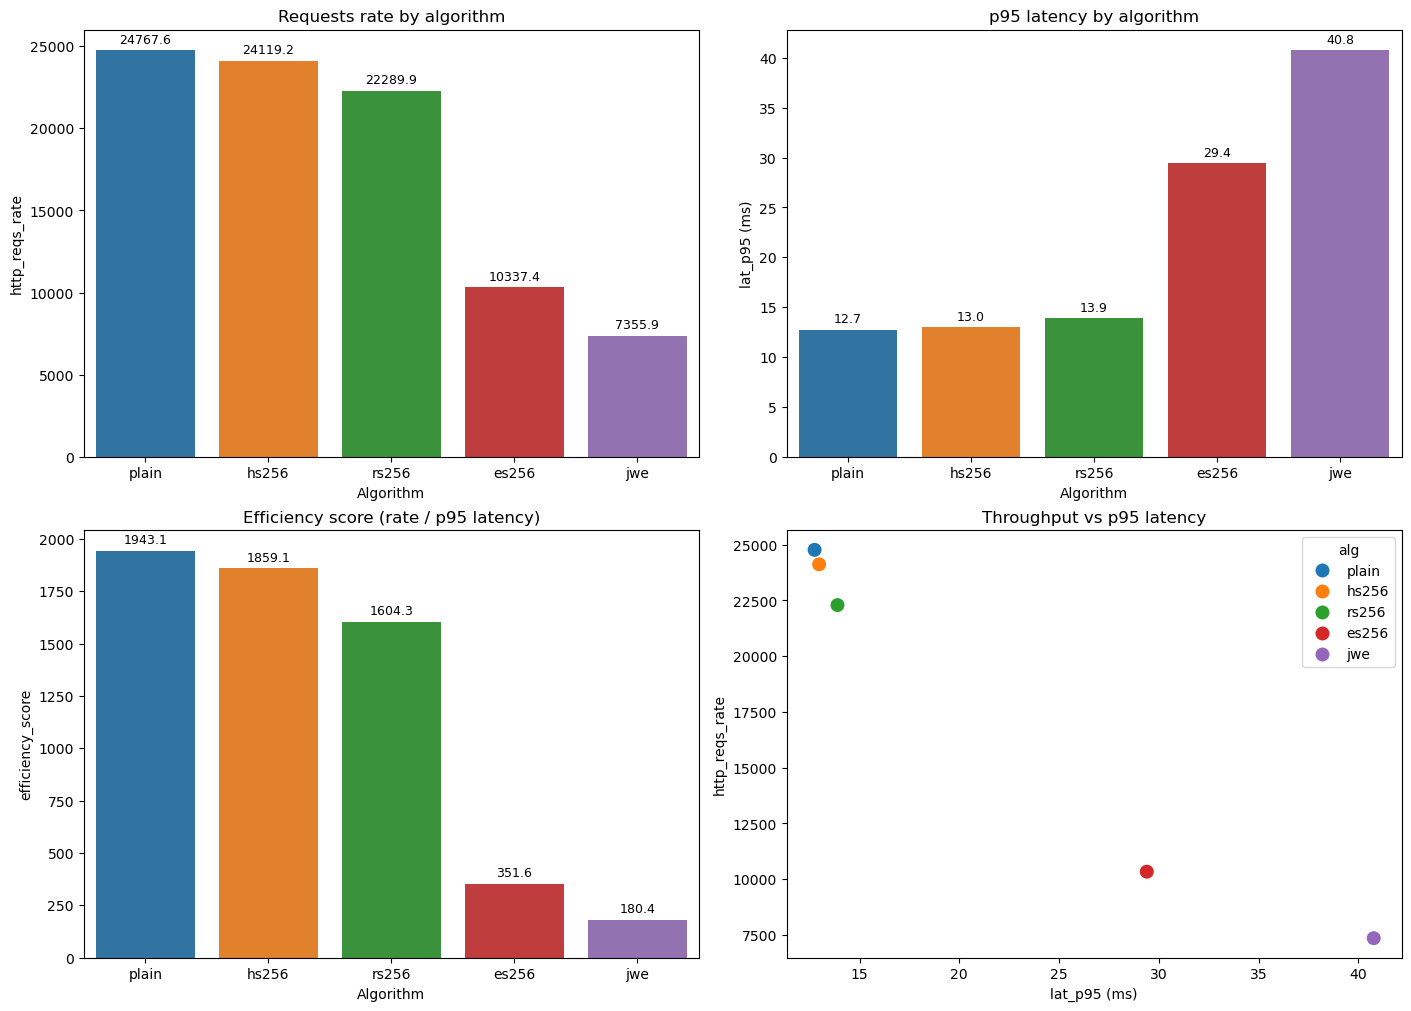

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_theme(style="whitegrid")

alg_order = (
    df.groupby("alg")["http_reqs_rate"]
      .mean()
      .sort_values(ascending=False)
      .index
      .tolist()
)
palette = sns.color_palette("tab10", n_colors=len(alg_order))
alg_palette = dict(zip(alg_order, palette))

df["efficiency_score"] = df["http_reqs_rate"] / df["lat_p95"]

def annotate_bars(ax, fmt="%.1f", fontsize=9, padding=3):
    for container in ax.containers:
        ax.bar_label(container, fmt=fmt, padding=padding, fontsize=fontsize)


fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

# 1) Requests rate
ax = axes[0, 0]
sns.barplot(
    data=df,
    x="alg",
    y="http_reqs_rate",
    order=alg_order,
    hue="alg",
    hue_order=alg_order,
    palette=alg_palette,
    legend=False,
    ax=ax,
)
annotate_bars(ax, fmt="%.1f")
ax.set_title("Requests rate by algorithm")
ax.set_xlabel("Algorithm")
ax.set_ylabel("http_reqs_rate")

# 2) p95 latency
ax = axes[0, 1]
sns.barplot(
    data=df,
    x="alg",
    y="lat_p95",
    order=alg_order,
    hue="alg",
    hue_order=alg_order,
    palette=alg_palette,
    legend=False,
    ax=ax,
)
annotate_bars(ax, fmt="%.1f")
ax.set_title("p95 latency by algorithm")
ax.set_xlabel("Algorithm")
ax.set_ylabel("lat_p95 (ms)")

# 3) Efficiency score
ax = axes[1, 0]
sns.barplot(
    data=df,
    x="alg",
    y="efficiency_score",
    order=alg_order,
    hue="alg",
    hue_order=alg_order,
    palette=alg_palette,
    legend=False,
    ax=ax,
)
annotate_bars(ax, fmt="%.1f")
ax.set_title("Efficiency score (rate / p95 latency)")
ax.set_xlabel("Algorithm")
ax.set_ylabel("efficiency_score")

# 4) Scatter: throughput vs p95 latency
ax = axes[1, 1]
sns.scatterplot(
    data=df,
    x="lat_p95",
    y="http_reqs_rate",
    hue="alg",
    hue_order=alg_order,
    palette=alg_palette,
    s=120,
    ax=ax,
)
ax.set_title("Throughput vs p95 latency")
ax.set_xlabel("lat_p95 (ms)")
ax.set_ylabel("http_reqs_rate")

plt.show()
